<a href="https://colab.research.google.com/github/bhushanrajs/distribution_factors_pySR/blob/main/df_skew_correction_PySR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Symbolic Regression

In [2]:
%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.8.5"
export JULIA_PKG_PRECOMPILE_AUTO=0
#---------------------------------------------------#

if [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  echo "Installing PyCall.jl..."
  julia -e 'using Pkg; Pkg.add("PyCall"); Pkg.build("PyCall")'
  julia -e 'println("Success")'

fi

Installing Julia 1.8.5 on the current Colab Runtime...
2024-07-17 18:54:27 URL:https://storage.googleapis.com/julialang2/bin/linux/x64/1.8/julia-1.8.5-linux-x86_64.tar.gz [130873886/130873886] -> "/tmp/julia.tar.gz" [1]
Installing PyCall.jl...
  Installing known registries into `~/.julia`
    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed VersionParsing ── v1.3.0
   Installed Parsers ───────── v2.8.1
   Installed Conda ─────────── v1.10.2
   Installed MacroTools ────── v0.5.13
   Installed PyCall ────────── v1.96.4
   Installed JSON ──────────── v0.21.4
   Installed Preferences ───── v1.4.3
   Installed PrecompileTools ─ v1.2.1
    Updating `~/.julia/environments/v1.8/Project.toml`
  [438e738f] + PyCall v1.96.4
    Updating `~/.julia/environments/v1.8/Manifest.toml`
  [8f4d0f93] + Conda v1.10.2
  [682c06a0] + JSON v0.21.4
  [1914dd2f] + MacroTools v0.5.13
  [69de0a69] + Parsers v2.8.1
  [aea7be01] + PrecompileTools v1.2.1
  [21216c

Install PySR and PyTorch-Lightning:

In [3]:
%pip install -Uq pysr pytorch_lightning --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.1/80.1 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 812.3/812.3 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 39.8 MB/s eta 0:00:00


In [4]:
%pip install julia

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 1.0 MB/s eta 0:00:00


In [5]:
from julia import Julia

julia = Julia(compiled_modules=False, threads="auto")
from julia import Main
from julia.tools import redirect_output_streams

redirect_output_streams()

In [ ]:
import pysr

# We don't precompile in colab because compiled modules are incompatible static Python libraries:
pysr.install(precompile=False)

[juliapkg] Found dependencies: /usr/local/lib/python3.10/dist-packages/juliapkg/juliapkg.json
[juliapkg] Found dependencies: /usr/local/lib/python3.10/dist-packages/pysr/juliapkg.json
[juliapkg] Found dependencies: /usr/local/lib/python3.10/dist-packages/juliacall/juliapkg.json
[juliapkg] Locating Julia ~1.6.7, ~1.7, ~1.8, ~1.9, =1.10.0, ~1.10.3
[juliapkg] Using Julia 1.8.5 at /usr/local/bin/julia
[juliapkg] Using Julia project at /root/.julia/environments/pyjuliapkg
[juliapkg] Installing packages:
           julia> import Pkg
           julia> Pkg.Registry.update()
           julia> Pkg.add([Pkg.PackageSpec(name="SymbolicRegression", uuid="8254be44-1295-4e6a-a16d-46603ac705cb"), Pkg.PackageSpec(name="Serialization", uuid="9e88b42a-f829-5b0c-bbe9-9e923198166b"), Pkg.PackageSpec(name="PythonCall", uuid="6099a3de-0909-46bc-b1f4-468b9a2dfc0d")])
           julia> Pkg.resolve()
           julia> Pkg.precompile()


In [1]:
import sympy
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pysr import PySRRegressor
from sklearn.model_selection import train_test_split

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/bhushanrajs/distribution_factors_pySR/main/psc_i.csv')

In [3]:
print(df.head(5))

                             model  skew girderName   L   D  w_oh    ts  S  \
0   Tx28-L_42-Nb_4-S_60-O_15-ts_85     0       Tx28  42  28   1.5   8.5  6   
1  Tx28-L_42-Nb_4-S_60-O_15-ts_100     0       Tx28  42  28   1.5  10.0  6   
2   Tx28-L_42-Nb_4-S_60-O_20-ts_85     0       Tx28  42  28   2.0   8.5  6   
3  Tx28-L_42-Nb_4-S_60-O_20-ts_100     0       Tx28  42  28   2.0  10.0  6   
4   Tx28-L_42-Nb_4-S_60-O_25-ts_85     0       Tx28  42  28   2.5   8.5  6   

   Nb           Kg  ...     n_bm4      n_r1      n_r2      n_r3      n_r4  \
0   4  555508.7064  ...  0.000520  0.925505  0.086994  0.026596 -0.039095   
1   4  588747.3095  ...  0.000889  0.923853  0.093144  0.036185 -0.053182   
2   4  555508.7064  ...  0.000448  0.993568  0.023006  0.024837 -0.041411   
3   4  588747.3095  ...  0.000803  0.991692  0.031001  0.033527 -0.056219   
4   4  555508.7064  ...  0.000379  1.060984 -0.039607  0.022209 -0.043585   

     sum_RY      d-G1      d-G2      d-G3          d-G4  
0  0.00003

In [79]:
df['x_trial'] = ((df['S']+df['w_oh'])*np.tan(np.radians(df['skew'])))/df['L']

girderName = df.loc[(df['skew'] == 0) & (df['ts'] == 8.5), 'girderName'].values
L = df.loc[(df['skew'] == 0) & (df['ts'] == 8.5), 'L'].values
D = df.loc[(df['skew'] == 0) & (df['ts'] == 8.5), 'D'].values
S = df.loc[(df['skew'] == 0) & (df['ts'] == 8.5), 'S'].values
w_oh = df.loc[(df['skew'] == 0) & (df['ts'] == 8.5), 'w_oh'].values
ts = df.loc[(df['skew'] == 0) & (df['ts'] == 8.5), 'ts'].values
Nb = df.loc[(df['skew'] == 0) & (df['ts'] == 8.5), 'Nb'].values
Kg = df.loc[(df['skew'] == 0) & (df['ts'] == 8.5), 'Kg'].values
skew = df.loc[(df['skew'] == 60), 'skew'].values * np.pi / 180
O = (w_oh * 10).astype(int)
tss = (ts * 10).astype(int)
models = girderName + '-L_' + L.astype(str) + '-Nb_' + Nb.astype(str) + '-S_' + (S*10).astype(str) + '-O_' + O.astype(str) + '-ts_' + tss.astype(str)
print(models)
# n_r1_sk0 = df.loc[(df['skew'] == 0) & (df['ts'] == 8.5), 'n_r1'].values
# n_r1_sk30 = df.loc[(df['skew'] == 30), 'n_r1'].values
# n_r1_sk45 = df.loc[(df['skew'] == 45), 'n_r1'].values
# n_r1_sk60 = df.loc[(df['skew'] == 60), 'n_r1'].values

# x_trial = df.loc[(df['skew'] != 0), 'x_trial'].values
# x_trial30 = df.loc[(df['skew'] == 30), 'x_trial'].values
# x_trial45 = df.loc[(df['skew'] == 45), 'x_trial'].values
# x_trial60 = df.loc[(df['skew'] == 60), 'x_trial'].values

# n_r1_skew = df.loc[(df['skew'] != 0), 'n_r1'].values
# sk30_r1_correction = n_r1_sk30 / n_r1_sk0
# sk45_r1_correction = n_r1_sk45 / n_r1_sk0
# sk60_r1_correction = n_r1_sk60 / n_r1_sk0
# # sk_r1_correction = n_r1_skew / n_r1_sk0

skews = [30, 45, 60]
sk_bm1_correction = []
sk_bm2_correction = []
sk_r1_correction = []
sk_r2_correction = []
x_L, x_S, x_D, x_Nb, x_skew, x_w_oh, x_trial, x_tan_skew, x_AR = [], [], [], [], [], [], [], [], []

for skew in skews:
  for model in models:
    skew_model = model + '-sk_' + str(skew)
    normal_model = model
    n_bm1_skewed = df.loc[(df['model'] == skew_model) , 'n_bm1'].values
    n_bm1_normal = df.loc[(df['model'] == normal_model) , 'n_bm1'].values
    n_bm2_skewed = df.loc[(df['model'] == skew_model) , 'n_bm2'].values
    n_bm2_normal = df.loc[(df['model'] == normal_model) , 'n_bm2'].values
    n_r1_skewed = df.loc[(df['model'] == skew_model) , 'n_r1'].values
    n_r1_normal = df.loc[(df['model'] == normal_model) , 'n_r1'].values
    n_r2_skewed = df.loc[(df['model'] == skew_model) , 'n_r2'].values
    n_r2_normal = df.loc[(df['model'] == normal_model) , 'n_r2'].values
    sk_bm1_correction.extend(n_bm1_skewed / n_bm1_normal)
    sk_bm2_correction.extend(n_bm2_skewed / n_bm2_normal)
    sk_r1_correction.extend(n_r1_skewed / n_r1_normal)
    sk_r2_correction.extend(n_r2_skewed / n_r2_normal)
    x_L.extend(df.loc[(df['model'] == skew_model) , 'L'].values)
    x_S.extend(df.loc[(df['model'] == skew_model) , 'S'].values)
    x_D.extend(df.loc[(df['model'] == skew_model) , 'D'].values)
    x_Nb.extend(df.loc[(df['model'] == skew_model) , 'Nb'].values)
    x_skew.extend(df.loc[(df['model'] == skew_model) , 'skew'].values * np.pi / 180)
    # x_tan_skew.extend(np.tan(df.loc[(df['model'] == skew_model) , 'skew'].values * np.pi / 180))
    x_w_oh.extend(df.loc[(df['model'] == skew_model) , 'w_oh'].values)
    x_trial.extend(df.loc[(df['model'] == skew_model) , 'x_trial'].values)


['Tx28-L_42-Nb_4-S_60-O_15-ts_85' 'Tx28-L_42-Nb_4-S_60-O_20-ts_85'
 'Tx28-L_42-Nb_4-S_60-O_25-ts_85' ... 'Tx84-L_210-Nb_7-S_120-O_36-ts_85'
 'Tx84-L_210-Nb_7-S_120-O_48-ts_85' 'Tx84-L_210-Nb_7-S_120-O_60-ts_85']


In [80]:
x_tan_skew = np.tan(x_skew)
print(sk_r1_correction[2304:])
print(x_skew)
print(x_tan_skew)

[1.1267781697326704, 1.0664851732421914, 1.0107055723044707, 0.966394284508426, 1.0331319184125898, 1.00052067873548, 1.0465300582322241, 1.0889794854839523, 1.009419621981651, 1.0465479588659616, 1.0847276156135186, 1.1200367176282497, 1.2485091975959965, 1.1895821438134393, 1.1354103571418066, 1.085026387212314, 1.1077434388239578, 1.050405841791495, 0.997135733583743, 0.9680875083568119, 1.0418997195823292, 0.9944926811454007, 1.0048613140577212, 1.0402975913129113, 1.3721345430807996, 1.3125595698181913, 1.2583419279740737, 1.2079057967092597, 1.1922427736247678, 1.1366733665849926, 1.0851885735431677, 1.0370949626539192, 1.0983014733547056, 1.0535639883308565, 1.0113137733494406, 0.9712973622254487, 1.1571235986169868, 1.1024005308167804, 1.0514945736219976, 1.0039592439837683, 1.0528499353047458, 0.9854367813579458, 1.040743101044214, 1.091299945311964, 1.0168185308141606, 1.03337268025394, 1.0782576721611141, 1.1191771856636843, 1.288527686508389, 1.2342003285876226, 1.184112883

In [83]:
X = np.stack((x_L, x_S, x_w_oh, x_tan_skew, x_trial), axis=-1)
y = sk_r1_correction
print(X.shape)
# print(y.shape)
print(X)

(3456, 5)
[[4.20000000e+01 6.00000000e+00 1.50000000e+00 5.77350269e-01
  1.03098262e-01]
 [4.20000000e+01 6.00000000e+00 2.00000000e+00 5.77350269e-01
  1.09971480e-01]
 [4.20000000e+01 6.00000000e+00 2.50000000e+00 5.77350269e-01
  1.16844697e-01]
 ...
 [2.10000000e+02 1.20000000e+01 3.61111111e+00 1.73205081e+00
  1.28758274e-01]
 [2.10000000e+02 1.20000000e+01 4.80555556e+00 1.73205081e+00
  1.38609886e-01]
 [2.10000000e+02 1.20000000e+01 6.00000000e+00 1.73205081e+00
  1.48461498e-01]]


In [82]:
# Learn equations
default_pysr_params = dict(
    populations=50,
    model_selection="best",
)

# model = PySRRegressor(
#     niterations=30,
#     binary_operators=['+', '-', '*', '/', '^'],
#     unary_operators=["square", "cube", "sqrt"],
#     **default_pysr_params
# )

model = PySRRegressor(
    niterations=100,  # < Increase me for better results
    binary_operators=['+', '-', '*', '/', "physics(x, y) = x^2 / y"],
    unary_operators=["square", "sqrt"],
        # ^ Custom operator (julia syntax)
    extra_sympy_mappings={"inv": lambda x: 1 / x,
                          "physics": lambda x, y: x**2 / y},
    # ^ Define operator for SymPy as well
    loss="loss(prediction, target) = (prediction - target)^2",
    constraints = {'^':(-4,4),'mult' : (3,3)},
    # ^ Custom loss function (julia syntax)
    **default_pysr_params
)

model.fit(X, y)

print(model)

/usr/local/lib/python3.10/dist-packages/pysr/sr.py:915: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pysr/sr.py:2582: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!


Streaming output truncated to the last 5000 lines.
13          2.525e-03  1.026e-01  y = sqrt((physics(physics(-0.69852, x₄), x₂) - -0.79067) ^ inv...
                                  (x₁ / x₃))
14          2.521e-03  1.623e-03  y = sqrt((physics(physics(0.71171, x₄), x₂) + sqrt(x₄)) ^ inv(...
                                  x₁ / x₃))
15          2.471e-03  1.984e-02  y = sqrt((physics(physics(-0.71128, x₄), x₂) + physics(x₄, 0.1...
                                  6768)) ^ inv(x₁ / x₃))
16          2.413e-03  2.386e-02  y = sqrt((x₄ + ((sqrt(x₃) / x₂) / physics(x₄, 0.23986))) ^ inv...
                                  (x₁ / x₃))
17          2.403e-03  4.447e-03  y = sqrt((sqrt(x₄) + ((sqrt(x₃) / x₂) / physics(x₄, 0.20329)))...
                                   ^ inv(x₁ / x₃))
18          2.378e-03  1.032e-02  y = sqrt((((sqrt(x₃) / x₂) / physics(x₄, 0.20329)) + (0.40786 ...
                                  + x₄)) ^ inv(x₁ / x₃))
19          2.318e-03  2.554e-02  y = sqrt(sqrt((s

In [84]:
n = 4
model.sympy(n)


(x4**(-0.06331438))**x3

In [85]:
y_pred = model.predict(X,n)
print("Default selection MSE:", np.power(y_pred - y, 2).mean())

Default selection MSE: 0.008267916881256594


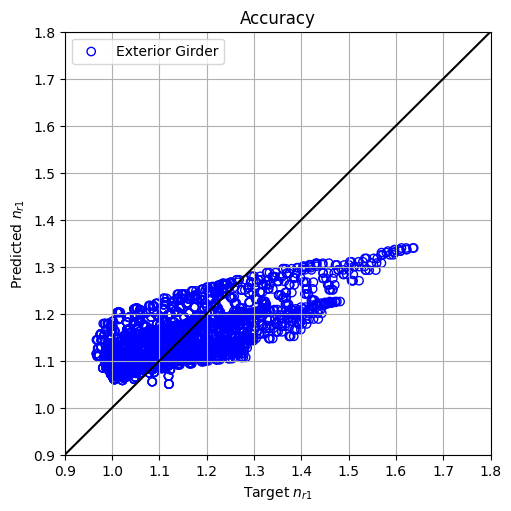

In [86]:
x_line = [0.9, 1.8]
y_line = [0.9, 1.8]
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(5, 5), constrained_layout = True)
ax1.scatter(x=y, y=y_pred, marker='o', c='none', edgecolor='b', label='Exterior Girder')
ax1.plot(x_line, y_line, c = "k")
ax1.set_title('Accuracy')
ax1.legend()
plt.xlim((0.9,1.8))
plt.ylim((0.9,1.8))
ax1.set_xlabel('Target $n_{r1}$')
ax1.set_ylabel('Predicted $n_{r1}$')
ax1.grid()

x3
Default selection MSE: 0.2209980181127687
1.13247483360632
Default selection MSE: 0.014658688325746379
x4**(-0.058972664)
Default selection MSE: 0.012318863226330556
3.0278397**(1/x1)
Default selection MSE: 0.0098483557808788
(x4**(-0.06331438))**x3
Default selection MSE: 0.008267916881256594
sqrt(1.025432**(x3/x4))
Default selection MSE: 0.006429114563767426
(x4**(-0.49815857/x1))**x3
Default selection MSE: 0.004599869757882363
((0.33459965922681/x4)**(1/x1))**x3
Default selection MSE: 0.0035129842948308405
((6.09641864058033*x4**2)**(-0.42632854/x1))**x3
Default selection MSE: 0.0032419263990274643
((0.370042564710338/x4)**(1/x1))**(x3 - x4)
Default selection MSE: 0.0031398368904074613
sqrt(((0.48793102862436/x4)**(2*x3)/x2)**(1/x1))
Default selection MSE: 0.00271229262535953
sqrt((0.73032194 + (0.46305262211209/x4)**(2*x3)/x2)**(1/x1))
Default selection MSE: 0.002391674440940319
sqrt((x3 + (-x4 + 0.469801440029597/x4)**(2*x3)/x2)**(1/x1))
Default selection MSE: 0.0023531379184851

IndexError: single positional indexer is out-of-bounds

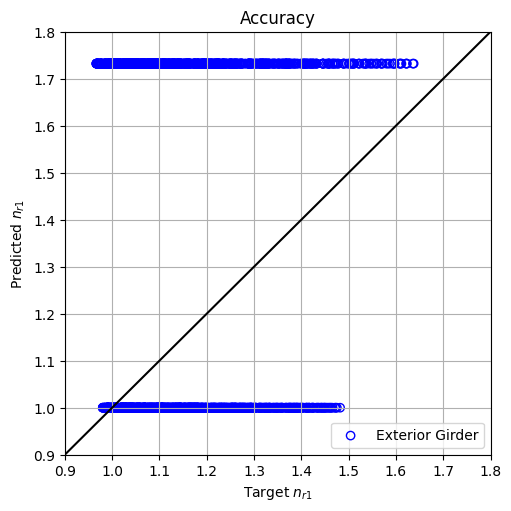

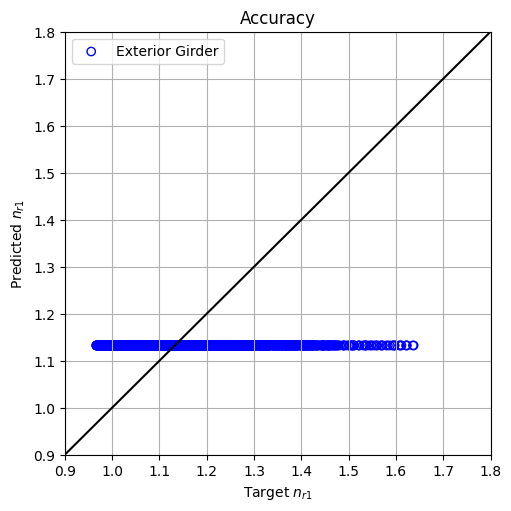

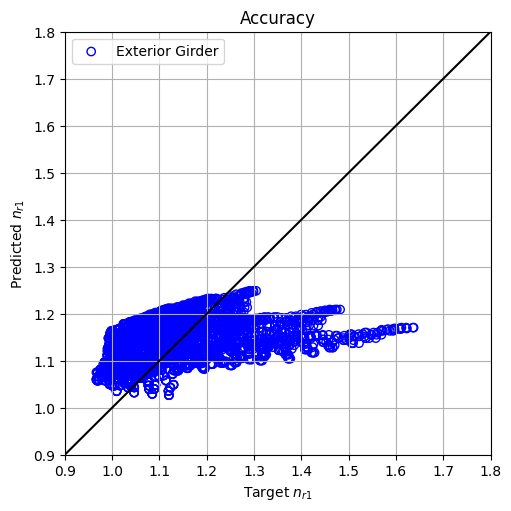

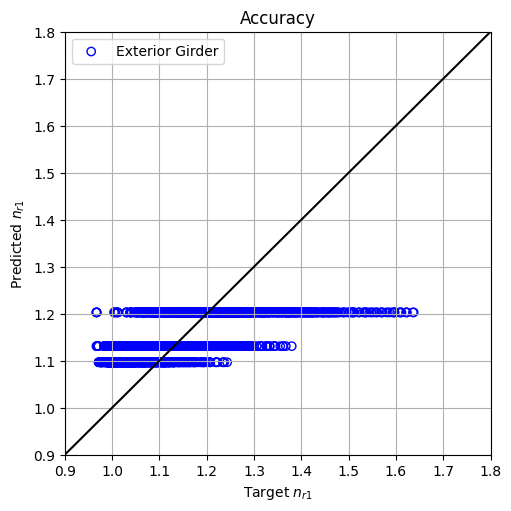

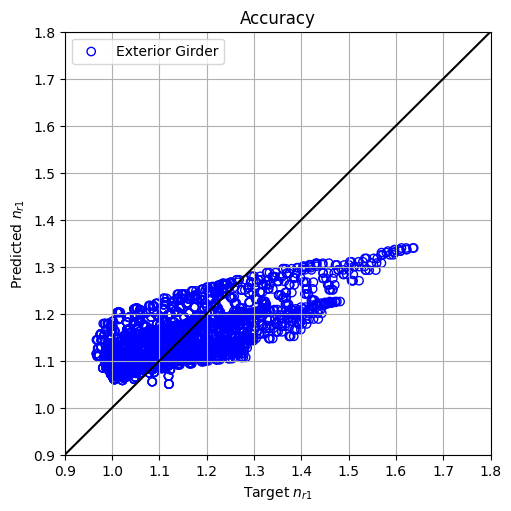

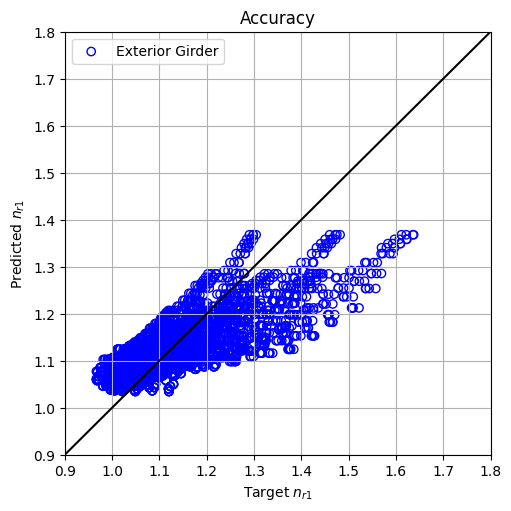

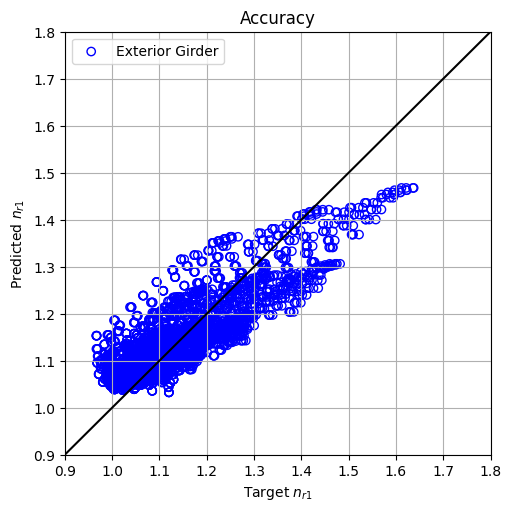

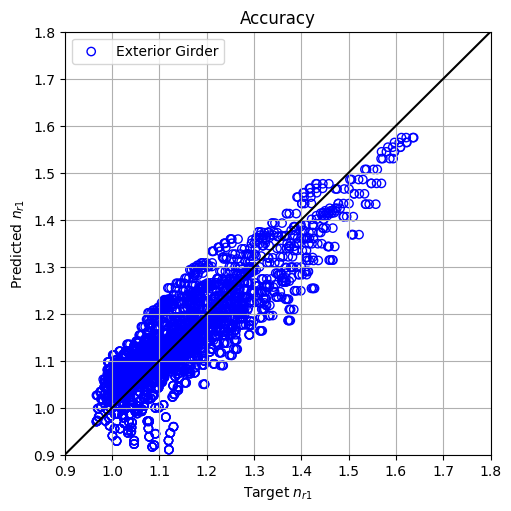

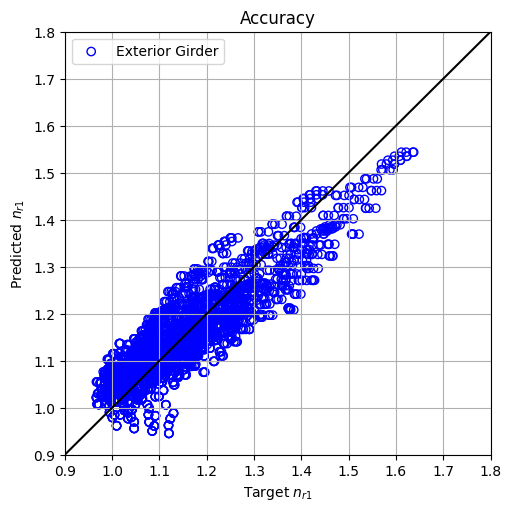

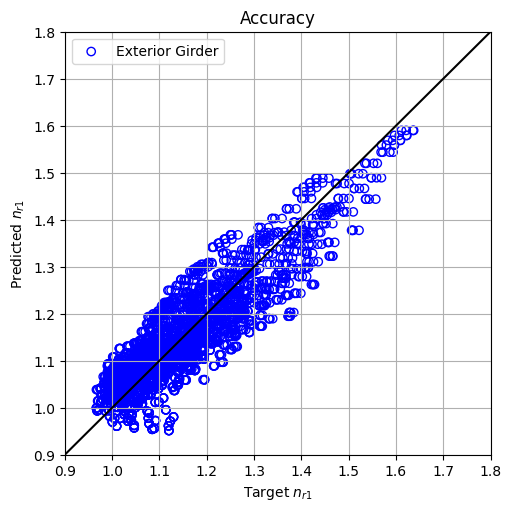

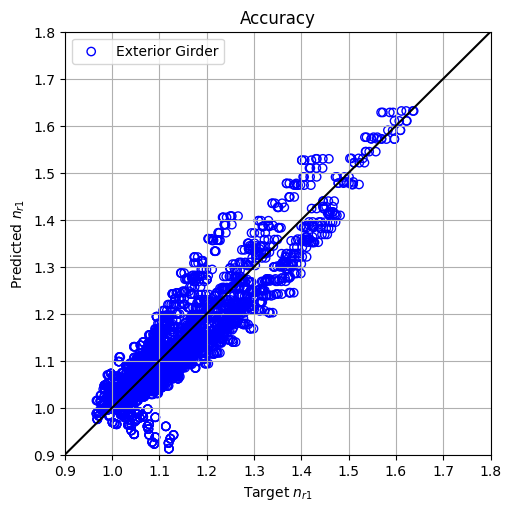

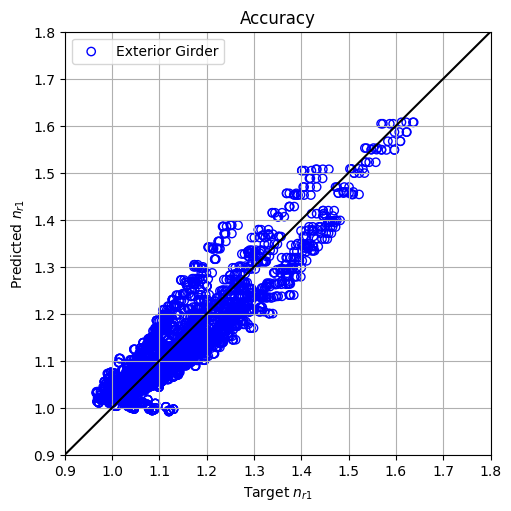

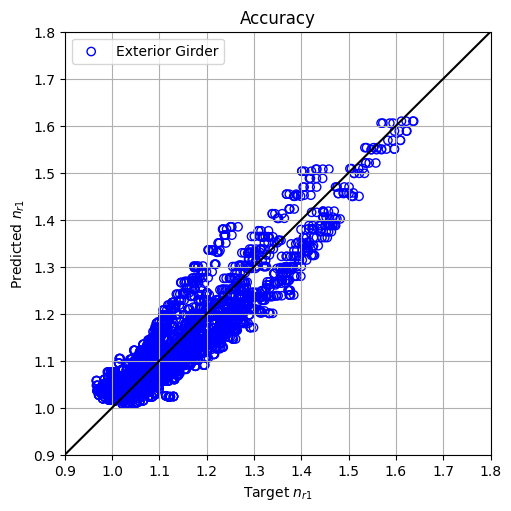

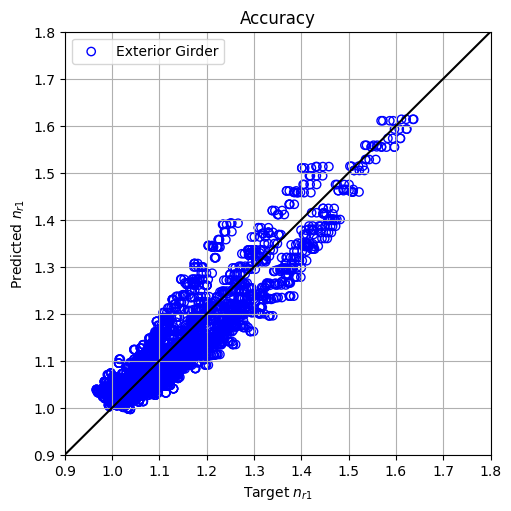

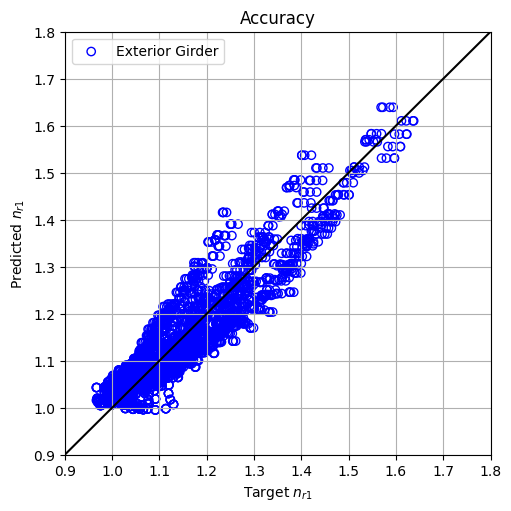

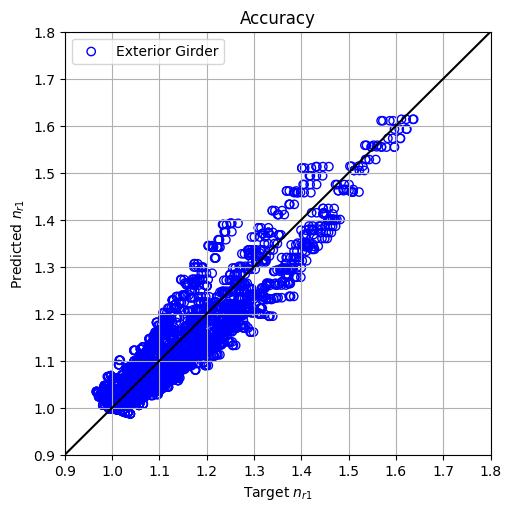

In [87]:
for i in range(20):
  print(model.sympy(i))
  y_pred = model.predict(X,i)
  print("Default selection MSE:", np.power(y_pred - y, 2).mean())
  x_line = [0.9, 1.8]
  y_line = [0.9, 1.8]
  fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(5, 5), constrained_layout = True)
  ax1.scatter(x=y, y=y_pred, marker='o', c='none', edgecolor='b', label='Exterior Girder')
  ax1.plot(x_line, y_line, c = "k")
  ax1.set_title('Accuracy')
  ax1.legend()
  plt.xlim((0.9,1.8))
  plt.ylim((0.9,1.8))
  ax1.set_xlabel('Target $n_{r1}$')
  ax1.set_ylabel('Predicted $n_{r1}$')
  ax1.grid()

In [ ]:
model.latex()

'0.000762 x_{4} + 0.843 + \\frac{0.0247}{x_{5}}'

$0.000762 D_{4} + 0.843 + \frac{0.0247 L}{(S+w_{oh})tan(skew)(D/28)}$

In [ ]:
X = np.stack((L, w_oh, S, skew, D, x_trial45), axis=-1)
y2 = sk_r2_correction

model.fit(X, y2)

print(model)


/usr/local/lib/python3.10/dist-packages/pysr/sr.py:1837: UserWarning: The discovered expressions are being reset. Please set `warm_start=True` if you wish to continue to start a search where you left off.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pysr/sr.py:1302: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                          1.4269581   
	1         1.924794                                 square(-1.0682441)   
	2         1.095785                                      1.364004 - x5   
	3         0.356175                               inv(0.65827763 + x5)   
	4         0.738792             physics(-0.25471932, x5) - -0.81485933   
	5         0.030668                inv(square(cos(0.0054620965 ^ x5)))   
	6         0.085617   sqrt(sin(physics(x5, 0.07859973)) ^ -0.35894832)   
	7         0.154061   (0.83545125 + physics(-0.2551507, x5)) - inv(x4)   
	8         0.232642  (0.83545125 + physics(-0.25471932, x5)) - (-0....   
	9         0.489870  square(inv(cos((0.18702415 / physics(x3, x0)) ...   
	10  >>>>  0.263654  square(-0.98269266 / cos(physics(-0.83383566, ...   
	11        0.000067  square(-0.98269266 / cos(tan(physics(-0.833835...   
	12      

In [ ]:
model.sympy(4)

0.81485933 + 0.0648819319812624/x5

In [ ]:
y2_pred = model.predict(X,4)
print("Default selection MSE:", np.power(y2_pred - y2, 2).mean())

Default selection MSE: 0.001560400606503654


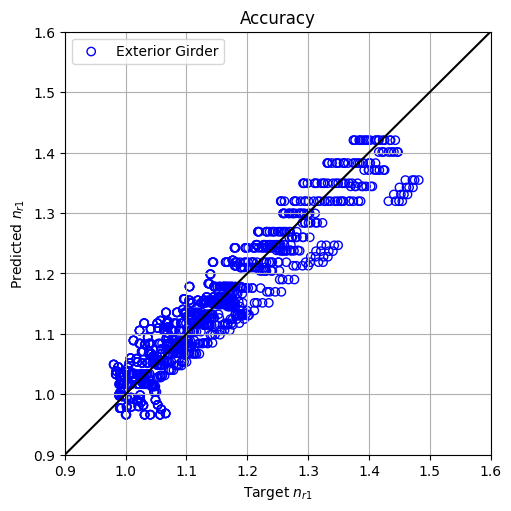

In [ ]:
x_line = [0.9, 1.6]
y_line = [0.9, 1.6]

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(5, 5), constrained_layout = True)

ax1.scatter(x=y2, y=y2_pred, marker='o', c='none', edgecolor='b', label='Exterior Girder')
ax1.plot(x_line, y_line, c = "k")
ax1.set_title('Accuracy')
ax1.legend()
plt.xlim((0.9,1.6))
plt.ylim((0.9,1.6))
ax1.set_xlabel('Target $n_{r1}$')
ax1.set_ylabel('Predicted $n_{r1}$')
ax1.grid()

In [ ]:
model.latex()

In [ ]:
X3 = np.stack((L, w_oh, S, skew, D, x_trial60), axis=-1)
y3 = sk60_r1_correction

model.fit(X3, y3)

print(model)

PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                          1.5523299   
	1         2.072110                                  square(1.0760698)   
	2         0.717330                                     1.5438924 - x5   
	3         0.173832                               tan(0.66311574 ^ x5)   
	4         0.490993                         inv(cos(-0.16622901 / x5))   
	5         0.111452                     cube(inv(cos(0.0288317 ^ x5)))   
	6         0.044025            square(inv(cube(cos(x5 - 0.55016536))))   
	7         0.016712  (physics(x5, 0.16705702) ^ -0.2638885) + cube(x5)   
	8         1.074089   cube(inv(cos((square(-0.024359057) * x4) ^ x5)))   
	9         0.082322  square(inv(cos(tan((square(-0.03031754) * x4) ...   
	10  >>>>  0.160782  cube(inv(cos(((square(0.028631318) * x4) - 0.0...   
	11        0.033087  cube(inv(cos(((x4 - square(x1)) * square(-0.02...   
	12      

/usr/local/lib/python3.10/dist-packages/pysr/sr.py:1837: UserWarning: The discovered expressions are being reset. Please set `warm_start=True` if you wish to continue to start a search where you left off.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pysr/sr.py:1302: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


In [ ]:
model.sympy(4)

NameError: name 'model' is not defined

In [ ]:
y3_pred = model.predict(X3,4)
print("Default selection MSE:", np.power(y3_pred - y3, 2).mean())

Default selection MSE: 0.001560400606503654


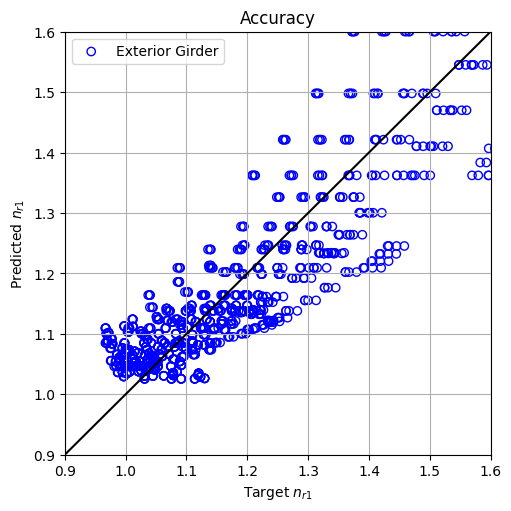

In [ ]:
x_line = [0.9, 1.6]
y_line = [0.9, 1.6]

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(5, 5), constrained_layout = True)

ax1.scatter(x=y3, y=y3_pred, marker='o', c='none', edgecolor='b', label='Exterior Girder')
ax1.plot(x_line, y_line, c = "k")
ax1.set_title('Accuracy')
ax1.legend()
plt.xlim((0.9,1.6))
plt.ylim((0.9,1.6))
ax1.set_xlabel('Target $n_{r1}$')
ax1.set_ylabel('Predicted $n_{r1}$')
ax1.grid()